In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
import os
import math
import datetime
from typing import Self
from tqdm.auto import tqdm
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [ ]:
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Configuración del modelo
T = 90
prediccion = 7
N_EPOCHS = 50
BATCH_SIZE = 128
LR = 0.0001
MAX_LEN = T
NUM_LAYERS = 3
D_MODEL = 128
NUM_HEAD = 8
DFF = 512
LSTM_HIDDEN_SIZE = 256
LSTM_LAYERS = 3
DROPOUT_RATE = 0.2

# Configuración de monitoreo y validación
MONITORING_CONFIG = {
    'log_every_n_steps': 10,
    'save_checkpoint_every': 5,
    'early_stop_patience': 15,
    'gradient_clip_value': 1.0
}

VALIDATION_CONFIG = {
    'val_split': 0.15,
    'test_split': 0.15,
    'train_split': 0.70
}

print("Configuration loaded successfully")


# Carga de datos


if os.path.exists("df_total.csv"):
    df_total = pd.read_csv("df_total.csv")
    print(f"Data loaded from CSV: {df_total.shape}")
else:
    with psycopg2.connect(
        host=os.getenv("DB_URL"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        database="postgres"
    ) as conn:
        with conn.cursor() as cursor:
            cursor.execute("SELECT * FROM datos_clima;")
            
            assert cursor.description is not None
            columns = [desc[0] for desc in cursor.description]
            data = cursor.fetchall()
    df_total = pd.DataFrame(data, columns=columns)
    df_total.to_csv("df_total.csv")
    print(f"Data loaded from database: {df_total.shape}")


Configuration loaded successfully
Data loaded from CSV: (2318209, 25)
Data loaded from CSV: (2318209, 25)


In [ ]:

# Preprocesamiento


features_originales = ['tmed', 'tmin', 'tmax', 'prec', 'altitud']
target_feature_name = 'tmed'

def advanced_feature_engineering(df):
    """Feature engineering avanzado para meteorología"""
    print("Applying advanced feature engineering...")
    
    df['fecha'] = pd.to_datetime(df['fecha'])
    
    # Features temporales
    df['day_of_year'] = df['fecha'].dt.dayofyear
    df['month'] = df['fecha'].dt.month
    df['season_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['season_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    
    # Features por estación meteorológica
    for station in df['indicativo'].unique():
        station_mask = df['indicativo'] == station
        station_data = df[station_mask].copy().sort_values('fecha')
        
        # Lag 
        for lag in [1, 3, 7]:
            df.loc[station_mask, f'tmed_lag_{lag}'] = station_data['tmed'].shift(lag)
            if 'prec' in df.columns:
                df.loc[station_mask, f'prec_lag_{lag}'] = station_data['prec'].shift(lag)
        
        # Rolling statistics
        for window in [3, 7, 14]:
            df.loc[station_mask, f'tmed_mean_{window}d'] = station_data['tmed'].rolling(window).mean()
            df.loc[station_mask, f'tmed_std_{window}d'] = station_data['tmed'].rolling(window).std()
            
            if 'prec' in df.columns:
                df.loc[station_mask, f'prec_mean_{window}d'] = station_data['prec'].rolling(window).mean()
        
        # Tendencias
        df.loc[station_mask, 'tmed_trend'] = station_data['tmed'].diff()
        df.loc[station_mask, 'tmed_trend_7d'] = station_data['tmed'].diff(7)
        
        # Ranges diarios
        if 'tmax' in df.columns and 'tmin' in df.columns:
            df.loc[station_mask, 'temp_range'] = station_data['tmax'] - station_data['tmin']
            df.loc[station_mask, 'temp_range_rolling_7d'] = df.loc[station_mask, 'temp_range'].rolling(7).mean()
    
    print(f"Feature engineering completed. New shape: {df.shape}")
    return df

def quality_filter_stations(df):
    """Filtro de calidad mejorado para estaciones"""
    print("Applying enhanced quality filters...")
    
    # Convertir a numérico
    for col in features_originales:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
    
    # Criterios de calidad
    min_registros = 200
    max_porcentaje_nulos = 10.0
    min_media_tmed = 5.0
    min_percentil75_tmed = 12.0
    min_temp_absoluta = -15.0
    max_temp_absoluta = 50.0
    
    # Filtro por cantidad de registros
    registros_por_estacion = df['indicativo'].value_counts()
    estaciones_suficientes = registros_por_estacion[registros_por_estacion >= min_registros].index
    df_filtrado = df[df['indicativo'].isin(estaciones_suficientes)].copy()
    print(f"Stations with sufficient records: {len(df_filtrado['indicativo'].unique())}")
    
    # Filtro por nulos
    nulos_por_estacion = df_filtrado.groupby('indicativo')['tmed'].apply(
        lambda x: x.isnull().sum() * 100 / len(x) if len(x) > 0 else 100
    )
    estaciones_pocos_nulos = nulos_por_estacion[nulos_por_estacion < max_porcentaje_nulos].index
    df_filtrado = df_filtrado[df_filtrado['indicativo'].isin(estaciones_pocos_nulos)].copy()
    print(f"Stations with low null values: {len(df_filtrado['indicativo'].unique())}")
    
    # Filtro por estadísticas de temperatura
    stats_por_estacion = df_filtrado.groupby('indicativo')['tmed'].agg([
        'mean', 'min', 'max', lambda x: x.quantile(0.75)
    ]).rename(columns={'<lambda_0>': 'p75'})
    
    estaciones_sanas = stats_por_estacion[
        (stats_por_estacion['mean'] >= min_media_tmed) &
        (stats_por_estacion['p75'] >= min_percentil75_tmed) &
        (stats_por_estacion['min'] >= min_temp_absoluta) &
        (stats_por_estacion['max'] <= max_temp_absoluta)
    ].index
    
    df_limpio = df_filtrado[df_filtrado['indicativo'].isin(estaciones_sanas)].copy()
    print(f"Stations with coherent temperatures: {len(df_limpio['indicativo'].unique())}")
    
    # Filtro por variabilidad
    variabilidad = df_limpio.groupby('indicativo')['tmed'].std()
    estaciones_variables = variabilidad[
        (variabilidad >= 2.0) & (variabilidad <= 15.0)
    ].index
    
    df_final = df_limpio[df_limpio['indicativo'].isin(estaciones_variables)].copy()
    print(f"Final high-quality stations: {len(df_final['indicativo'].unique())}")
    
    return df_final

# Aplicar preprocesamiento
print("Starting enhanced preprocessing...")
df_total['fecha'] = pd.to_datetime(df_total['fecha'])

# Feature engineering
df_enhanced = advanced_feature_engineering(df_total)

# Filtros de calidad
df_limpio = quality_filter_stations(df_enhanced)

print(f"Preprocessing summary:")
print(f"  Original dataset: {len(df_total)} records, {df_total['indicativo'].nunique()} stations")
print(f"  Filtered dataset: {len(df_limpio)} records, {df_limpio['indicativo'].nunique()} stations")
print(f"  Total features: {df_limpio.shape[1]} columns")


Starting enhanced preprocessing...
Applying advanced feature engineering...
Feature engineering completed. New shape: (2318209, 48)
Applying enhanced quality filters...
Feature engineering completed. New shape: (2318209, 48)
Applying enhanced quality filters...
Stations with sufficient records: 917
Stations with sufficient records: 917
Stations with low null values: 878
Stations with low null values: 878
Stations with coherent temperatures: 868
Stations with coherent temperatures: 868
Final high-quality stations: 868
Preprocessing summary:
  Original dataset: 2318209 records, 918 stations
  Filtered dataset: 2215026 records, 868 stations
  Total features: 48 columns
Final high-quality stations: 868
Preprocessing summary:
  Original dataset: 2318209 records, 918 stations
  Filtered dataset: 2215026 records, 868 stations
  Total features: 48 columns


In [ ]:

# Manejo inteligente de NaNs y preparación de features


def intelligent_nan_handling(df):
    """Manejo inteligente de NaNs por tipo de feature"""
    print("Applying intelligent NaN handling...")
    
    df_processed = df.copy()
    df_processed.sort_values(by=['indicativo', 'fecha'], inplace=True)
    df_processed.reset_index(drop=True, inplace=True)
    
    # Definir grupos de features
    core_features = ['tmed', 'tmin', 'tmax', 'prec', 'altitud']
    temporal_features = [col for col in df_processed.columns if any(x in col for x in ['lag_', 'mean_', 'std_', 'trend'])]
    seasonal_features = ['season_sin', 'season_cos', 'day_of_year', 'month']
    
    # Features principales: interpolación por estación
    for col in core_features:
        if col in df_processed.columns and df_processed[col].isnull().any():
            df_processed[col] = df_processed.groupby('indicativo')[col].transform(
                lambda x: x.interpolate(method='linear').fillna(x.mean())
            )
    
    # Features temporales: forward fill + backward fill por estación
    for col in temporal_features:
        if col in df_processed.columns and df_processed[col].isnull().any():
            df_processed[col] = df_processed.groupby('indicativo')[col].transform(
                lambda x: x.fillna(method='ffill').fillna(method='bfill').fillna(0)
            )
    
    # Features estacionales sin NaNs
    for col in seasonal_features:
        if col in df_processed.columns and df_processed[col].isnull().any():
            df_processed[col] = df_processed[col].fillna(0)
    
    # Verificación final
    remaining_nans = df_processed.isnull().sum()
    if remaining_nans.sum() > 0:
        print(f"Remaining NaNs by column:")
        for col, count in remaining_nans[remaining_nans > 0].items():
            print(f"  {col}: {count}")
        
        # Eliminar filas con NaNs en features críticos
        before_drop = len(df_processed)
        df_processed.dropna(subset=core_features, inplace=True)
        after_drop = len(df_processed)
        print(f"Removed {before_drop - after_drop} rows with critical NaNs")
    else:
        print("No remaining NaNs in dataset")
    
    df_processed.reset_index(drop=True, inplace=True)
    return df_processed

# Aplicar manejo de NaNs
df_processed = intelligent_nan_handling(df_limpio)

all_features = [col for col in df_processed.columns if col not in ['fecha', 'indicativo', 'indicativo_encoded']]
core_features = ['tmed', 'tmin', 'tmax', 'prec', 'altitud']

print(f"Features summary:")
print(f"  Core features: {len(core_features)}")
print(f"  Total features: {len(all_features)}")
print(f"  Enhanced features: {len(all_features) - len(core_features)}")

print(f"Data processing completed")
print(f"  Final shape: {df_processed.shape}")
print(f"  Date range: {df_processed['fecha'].min()} to {df_processed['fecha'].max()}")


Applying intelligent NaN handling...
Remaining NaNs by column:
  prec: 2896
  horatmin: 2215026
  horatmax: 2215026
  hrMax: 82788
  horaHrMax: 2215026
  hrMin: 82652
  horaHrMin: 2215026
  hrMedia: 111885
  dir: 450845
  velmedia: 443325
  racha: 450805
  horaracha: 2215026
  presMax: 1679423
  horaPresMax: 1794393
  presMin: 1679435
  horaPresMin: 1743964
  sol: 1828971
  temp_range: 21108
  temp_range_rolling_7d: 75862
Removed 2896 rows with critical NaNs
Features summary:
  Core features: 5
  Total features: 46
  Enhanced features: 41
Data processing completed
  Final shape: (2212130, 48)
  Date range: 2017-01-01 00:00:00 to 2024-12-31 00:00:00
Remaining NaNs by column:
  prec: 2896
  horatmin: 2215026
  horatmax: 2215026
  hrMax: 82788
  horaHrMax: 2215026
  hrMin: 82652
  horaHrMin: 2215026
  hrMedia: 111885
  dir: 450845
  velmedia: 443325
  racha: 450805
  horaracha: 2215026
  presMax: 1679423
  horaPresMax: 1794393
  presMin: 1679435
  horaPresMin: 1743964
  sol: 1828971
  tem

In [ ]:

# Preparación de datos


def temporal_split_strategy(df, validation_config):
    """División temporal estratégica para series de tiempo"""
    print("Applying strategic temporal split...")
    
    df_sorted = df.sort_values('fecha').reset_index(drop=True)
    
    # Obtener fechas únicas para split temporal
    unique_dates = sorted(df_sorted['fecha'].unique())
    total_dates = len(unique_dates)
    
    # Calcular índices de corte
    train_end_idx = int(total_dates * validation_config['train_split'])
    val_end_idx = int(total_dates * (validation_config['train_split'] + validation_config['val_split']))
    
    train_end_date = unique_dates[train_end_idx]
    val_end_date = unique_dates[val_end_idx]
    
    # Crear splits
    train_df = df_sorted[df_sorted['fecha'] <= train_end_date].copy()
    val_df = df_sorted[
        (df_sorted['fecha'] > train_end_date) & 
        (df_sorted['fecha'] <= val_end_date)
    ].copy()
    test_df = df_sorted[df_sorted['fecha'] > val_end_date].copy()
    
    print(f"Temporal split completed:")
    print(f"  Train: {len(train_df):,} records ({train_df['fecha'].min()} to {train_df['fecha'].max()})")
    print(f"  Val:   {len(val_df):,} records ({val_df['fecha'].min()} to {val_df['fecha'].max()})")
    print(f"  Test:  {len(test_df):,} records ({test_df['fecha'].min()} to {test_df['fecha'].max()})")
    
    return train_df, val_df, test_df

def advanced_window_segmentation(df, features_list, target_feature, window_size):
    """Segmentación de ventanas mejorada con validación"""
    print(f"Creating temporal windows (T={window_size})...")
    
    all_sequences = []
    all_targets = []
    station_info = []
    
    target_idx = features_list.index(target_feature)
    station_groups = df.groupby("indicativo")
    
    valid_stations = 0
    total_sequences = 0
    
    for station_name, group in station_groups:
        group_sorted = group.sort_values('fecha').reset_index(drop=True)
        data = group_sorted[features_list].to_numpy()
        
        if len(data) < window_size + 1:
            continue
        
        valid_stations += 1
        
        for i in range(len(data) - window_size):
            sequence = data[i:i+window_size]
            target = data[i+window_size, target_idx]
            
            if not (np.isnan(sequence).any() or np.isnan(target)):
                all_sequences.append(sequence)
                all_targets.append(target)
                station_info.append({
                    'station': station_name,
                    'date': group_sorted.iloc[i+window_size]['fecha']
                })
                total_sequences += 1
    
    print(f"Windows created successfully:")
    print(f"  Valid stations: {valid_stations}")
    print(f"  Total sequences: {total_sequences:,}")
    print(f"  Shape per sequence: {np.array(all_sequences[0]).shape if all_sequences else 'N/A'}")
    
    return np.array(all_sequences, dtype=np.float32), np.array(all_targets, dtype=np.float32), station_info

# Seleccionar estaciones para entrenamiento
print("Selecting stations for training...")
estaciones_unicas = df_processed['indicativo'].unique()
np.random.seed(42)
np.random.shuffle(estaciones_unicas)

# Usar 95% de estaciones para tener más datos
num_estaciones_subset = int(len(estaciones_unicas) * 0.95)
estaciones_subset = estaciones_unicas[:num_estaciones_subset]
df_for_processing = df_processed[df_processed['indicativo'].isin(estaciones_subset)].copy()

print(f"Using {len(estaciones_subset)} stations out of {len(estaciones_unicas)} available")

# División temporal
train_df, val_df, test_df = temporal_split_strategy(df_for_processing, VALIDATION_CONFIG)

# Seleccionar features mejoradas
selected_features = [
    'tmed', 'tmin', 'tmax', 'prec', 'altitud',  
    'season_sin', 'season_cos',  
    'tmed_lag_1', 'tmed_lag_3', 'tmed_lag_7',  
    'tmed_mean_7d', 'tmed_std_7d',  
    'temp_range'  
]

# Filtrar features que existen
available_features = [f for f in selected_features if f in df_for_processing.columns]
print(f"Selected features: {len(available_features)}")

# Crear secuencias para cada conjunto
X_train, y_train, train_info = advanced_window_segmentation(train_df, available_features, target_feature_name, T)
X_val, y_val, val_info = advanced_window_segmentation(val_df, available_features, target_feature_name, T)
X_test, y_test, test_info = advanced_window_segmentation(test_df, available_features, target_feature_name, T)

# Escalado
print("Applying scaling...")
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit solo en datos de entrenamiento
X_train_reshaped = X_train.reshape(-1, len(available_features))
X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# Transform validation y test
X_val_reshaped = X_val.reshape(-1, len(available_features))
X_val_scaled = scaler_X.transform(X_val_reshaped).reshape(X_val.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

X_test_reshaped = X_test.reshape(-1, len(available_features))
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Guardar escalers
from joblib import dump
scaler_save_path = "C:/Users/Luis/Desktop/modelito"
dump(scaler_X, os.path.join(scaler_save_path, 'scaler_X_production.joblib'))
dump(scaler_y, os.path.join(scaler_save_path, 'scaler_y_production.joblib'))

# Label encoder
label_encoder = LabelEncoder()
df_for_processing['indicativo_encoded'] = label_encoder.fit_transform(df_for_processing['indicativo'])
NUM_STATIONS = len(label_encoder.classes_)

encoder_save_path = os.path.join(scaler_save_path, 'label_encoder_global_all_stations.joblib')
dump(label_encoder, encoder_save_path)
print("Label encoder saved successfully")

# Conversión a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Variables globales
n_features = len(available_features)
target_idx = available_features.index(target_feature_name)

print(f"Data preparation completed:")
print(f"  Train: {X_train_tensor.shape[0]:,} sequences")
print(f"  Val:   {X_val_tensor.shape[0]:,} sequences")
print(f"  Test:  {X_test_tensor.shape[0]:,} sequences")
print(f"  Features: {n_features}")
print(f"  Time window: {T} days")


Selecting stations for training...
Using 818 stations out of 862 available
Applying strategic temporal split...
Using 818 stations out of 862 available
Applying strategic temporal split...
Temporal split completed:
  Train: 1,460,041 records (2017-01-01 00:00:00 to 2022-09-04 00:00:00)
  Val:   317,788 records (2022-09-05 00:00:00 to 2023-11-25 00:00:00)
  Test:  319,148 records (2023-11-26 00:00:00 to 2024-12-31 00:00:00)
Selected features: 13
Creating temporal windows (T=90)...
Temporal split completed:
  Train: 1,460,041 records (2017-01-01 00:00:00 to 2022-09-04 00:00:00)
  Val:   317,788 records (2022-09-05 00:00:00 to 2023-11-25 00:00:00)
  Test:  319,148 records (2023-11-26 00:00:00 to 2024-12-31 00:00:00)
Selected features: 13
Creating temporal windows (T=90)...
Windows created successfully:
  Valid stations: 810
  Total sequences: 1,062,946
  Shape per sequence: (90, 13)
Windows created successfully:
  Valid stations: 810
  Total sequences: 1,062,946
  Shape per sequence: (90,

In [ ]:

# Arquitectura de modelo mejorada


class AdvancedPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout_rate: float = 0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(
            embed_dim=d_model, 
            num_heads=n_heads, 
            dropout=dropout_rate,
            batch_first=True
        )
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_output, _ = self.mha(x, x, x, need_weights=False)
        return self.norm(x + self.dropout(attn_output))

class FeedForwardLayer(nn.Module):
    def __init__(self, d_model: int, dff: int, dropout_rate: float = 0.1):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dff, d_model),
            nn.Dropout(dropout_rate)
        )
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.norm(x + self.ffn(x))

class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dff: int, dropout_rate: float = 0.1):
        super().__init__()
        self.attention = MultiHeadAttentionLayer(d_model, n_heads, dropout_rate)
        self.feed_forward = FeedForwardLayer(d_model, dff, dropout_rate)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.attention(x)
        x = self.feed_forward(x)
        return x

class ProductionLSTMTransformerModel(nn.Module):
    def __init__(
        self,
        d_input: int,
        lstm_hidden_size: int,
        lstm_layers: int,
        n_transformer_layers: int,
        d_model: int,
        n_heads: int,
        dff: int,
        max_len: int,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        
        self.d_model = d_model
        self.input_projection = nn.Linear(d_input, lstm_hidden_size)
        
        # LSTM Stack
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(
                input_size=lstm_hidden_size if i == 0 else lstm_hidden_size * 2,
                hidden_size=lstm_hidden_size,
                batch_first=True,
                dropout=dropout_rate if i < lstm_layers - 1 else 0,
                bidirectional=True
            ) for i in range(lstm_layers)
        ])
        
        # Transformer dimension
        self.lstm_to_transformer = nn.Linear(lstm_hidden_size * 2, d_model)
        
        # Transformer Stack
        self.pos_encoding = AdvancedPositionalEncoding(d_model, max_len)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, dff, dropout_rate)
            for _ in range(n_transformer_layers)
        ])
        
        # Output layers
        self.output_norm = nn.LayerNorm(d_model)
        self.output_layers = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(d_model // 2, d_model // 4),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(d_model // 4, 1)
        )
        
      
        self.skip_connection = nn.Linear(d_input, 1)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Inicialización de pesos mejorada"""
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias' in name:
                    torch.nn.init.zeros_(param.data)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        
        
        skip = self.skip_connection(x[:, -1, :])
        
        # Input projection
        x = self.input_projection(x)
        
        # LSTM 
        for lstm in self.lstm_layers:
            x, _ = lstm(x)

        # Transformer dimension
        x = self.lstm_to_transformer(x)
        
        # Positional encoding
        x = self.pos_encoding(x)
        
        # Transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        # Output processing
        x = self.output_norm(x)
        x = x[:, -prediccion:, :].mean(dim=1)

        # Prediction
        main_output = self.output_layers(x)
        
        # Combine with skip connection
        output = main_output + 0.1 * skip
        
        return output

# Modelo
model = ProductionLSTMTransformerModel(
    d_input=n_features,
    lstm_hidden_size=LSTM_HIDDEN_SIZE,
    lstm_layers=LSTM_LAYERS,
    n_transformer_layers=NUM_LAYERS,
    d_model=D_MODEL,
    n_heads=NUM_HEAD,
    dff=DFF,
    max_len=MAX_LEN,
    dropout_rate=DROPOUT_RATE,
).to(DEV)

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")


with torch.no_grad():
    test_input = torch.randn(2, T, n_features).to(DEV)
    test_output = model(test_input)
    print(f"Test forward pass: {test_input.shape} -> {test_output.shape}")


c:\Users\Luis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Model created with 4,881,295 parameters
Test forward pass: torch.Size([2, 90, 13]) -> torch.Size([2, 1])
Test forward pass: torch.Size([2, 90, 13]) -> torch.Size([2, 1])


In [ ]:

# Entrenamiento con monitoreo


from torch.optim.lr_scheduler import OneCycleLR
import json
from datetime import datetime
import time

class TempDataset(Dataset):
    def __init__(self, data: torch.Tensor, labels: torch.Tensor):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def train_epoch(model, train_loader, optimizer, criterion, device, scaler_y, epoch_num):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    # Progreso durante entrenamiento
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        if targets.dim() == 1:
            targets = targets.unsqueeze(1)
            
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MONITORING_CONFIG['gradient_clip_value'])
        
        optimizer.step()
        total_loss += loss.item()
        
       
        if batch_idx % 500 == 0 and batch_idx > 0:
            current_loss = total_loss / (batch_idx + 1)
            progress = (batch_idx / len(train_loader)) * 100
            print(f"  Epoch {epoch_num} | Batch {batch_idx:,}/{len(train_loader):,} ({progress:.1f}%) | Loss: {current_loss:.4f}")
        
        # Guardar para métricas 
            all_preds.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    # Calcular métricas desnormalizadas
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    all_preds_denorm = scaler_y.inverse_transform(all_preds).flatten()
    all_targets_denorm = scaler_y.inverse_transform(all_targets).flatten()
    
    avg_loss = total_loss / len(train_loader)
    mae = mean_absolute_error(all_targets_denorm, all_preds_denorm)
    r2 = r2_score(all_targets_denorm, all_preds_denorm)
    
    return avg_loss, mae, r2

def validate_epoch(model, val_loader, criterion, device, scaler_y):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    print("  Validating...", end=" ")
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            if targets.dim() == 1:
                targets = targets.unsqueeze(1)
                
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Progress indicator
            if batch_idx % 200 == 0 and batch_idx > 0:
                print(".", end="")
    
    print(" Done!")
    
    # Calcular métricas desnormalizadas
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    all_preds_denorm = scaler_y.inverse_transform(all_preds).flatten()
    all_targets_denorm = scaler_y.inverse_transform(all_targets).flatten()
    
    avg_loss = total_loss / len(val_loader)
    mae = mean_absolute_error(all_targets_denorm, all_preds_denorm)
    rmse = np.sqrt(mean_squared_error(all_targets_denorm, all_preds_denorm))
    r2 = r2_score(all_targets_denorm, all_preds_denorm)
    
    return avg_loss, mae, rmse, r2

# Preparar datasets
train_dataset = TempDataset(X_train_tensor, y_train_tensor)
val_dataset = TempDataset(X_val_tensor, y_val_tensor)
test_dataset = TempDataset(X_test_tensor, y_test_tensor)

# DataLoaders optimizados (sin multiprocessing para Windows/Jupyter)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# Optimizer y Scheduler mejorados
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=LR, 
    weight_decay=1e-5,
    betas=(0.9, 0.999)
)

# OneCycle scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=LR * 3,
    epochs=N_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)

criterion = nn.SmoothL1Loss()

# Tracking
best_val_r2 = -float('inf')
best_val_mae = float('inf')
patience_counter = 0

history = {
    "train_loss": [], "train_mae": [], "train_r2": [],
    "val_loss": [], "val_mae": [], "val_rmse": [], "val_r2": [],
    "epochs": [], "lr": []
}

# Información inicial de timing
num_batches = len(train_loader)
estimated_time_per_batch = 0.5 
estimated_epoch_time = (num_batches * estimated_time_per_batch) / 60  

print("=" * 80)
print("TRAINING CONFIGURATION")
print("=" * 80)
print(f"Train samples: {len(train_dataset):,}")
print(f"Val samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Batches per epoch: {num_batches:,}")
print(f"Estimated time per epoch: ~{estimated_epoch_time:.1f} minutes")
print(f"Estimated total training time: ~{estimated_epoch_time * N_EPOCHS:.1f} minutes ({(estimated_epoch_time * N_EPOCHS)/60:.1f} hours)")
print("=" * 80)

# Training loop con timing
total_start_time = time.time()
epoch_times = []

for epoch in range(N_EPOCHS):
    epoch_start_time = time.time()
    print(f"\nEPOCH {epoch+1}/{N_EPOCHS}")
    print("-" * 40)
    
    # Train
    train_loss, train_mae, train_r2 = train_epoch(model, train_loader, optimizer, criterion, DEV, scaler_y, epoch+1)
    
    # Validate
    val_loss, val_mae, val_rmse, val_r2 = validate_epoch(model, val_loader, criterion, DEV, scaler_y)
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    # Update scheduler
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save best model
    improved = False
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        best_val_mae = val_mae
        patience_counter = 0
        improved = True
        
        # Guardar modelo
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_r2': val_r2,
            'val_mae': val_mae,
            'config': {
                'n_features': n_features,
                'T': T,
                'BATCH_SIZE': BATCH_SIZE,
                'LR': LR,
                'D_MODEL': D_MODEL,
                'NUM_HEAD': NUM_HEAD,
                'DFF': DFF,
                'LSTM_HIDDEN_SIZE': LSTM_HIDDEN_SIZE,
                'LSTM_LAYERS': LSTM_LAYERS,
                'NUM_LAYERS': NUM_LAYERS,
                'DROPOUT_RATE': DROPOUT_RATE
            }
        }, 'best_model_checkpoint.pth')
        
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= MONITORING_CONFIG['early_stop_patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break
    
    # Update history
    history["epochs"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["train_mae"].append(train_mae)
    history["train_r2"].append(train_r2)
    history["val_loss"].append(val_loss)
    history["val_mae"].append(val_mae)
    history["val_rmse"].append(val_rmse)
    history["val_r2"].append(val_r2)
    history["lr"].append(current_lr)
    
    # Timing calculations
    avg_epoch_time = np.mean(epoch_times)
    remaining_epochs = N_EPOCHS - (epoch + 1)
    estimated_remaining_time = (remaining_epochs * avg_epoch_time) / 60  
    total_elapsed = (time.time() - total_start_time) / 60 
    
    # Status report
    status = "IMPROVED " if improved else "STABLE"
    print(f"\nRESULTS:")
    print(f"  Status: {status}")
    print(f"  Train Loss: {train_loss:.4f} | Train MAE: {train_mae:.2f}°C | Train R²: {train_r2:.3f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val MAE:   {val_mae:.2f}°C | Val R²:   {val_r2:.3f}")
    print(f"  Learning Rate: {current_lr:.2e}")
    print(f"  Epoch Time: {epoch_time/60:.1f} min | Avg: {avg_epoch_time/60:.1f} min")
    print(f"  Total Elapsed: {total_elapsed:.1f} min | ETA: {estimated_remaining_time:.1f} min")
    print(f"  Patience: {patience_counter}/{MONITORING_CONFIG['early_stop_patience']}")
    
    # Update learning rate
    scheduler.step()

# Final summary
total_time = (time.time() - total_start_time) / 60
print("\n" + "=" * 80)
print("TRAINING COMPLETED")
print("=" * 80)
print(f"Total training time: {total_time:.1f} minutes ({total_time/60:.1f} hours)")
print(f"Best validation R²: {best_val_r2:.4f}")
print(f"Best validation MAE: {best_val_mae:.2f}°C")
print(f"Epochs completed: {len(history['epochs'])}")

# Guardar historial
with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=2)
    


Starting comprehensive evaluation...


C:\Users\Luis\AppData\Local\Temp\ipykernel_36780\207136055.py:36: RuntimeWarning: divide by zero encountered in divide
  'mape': np.mean(np.abs((targets_denorm - predictions_denorm) / targets_denorm)) * 100


Analyzing feature importance...

FINAL MODEL METRICS:
  MAE:  1.46°C
  RMSE: 1.89°C
  R²:   0.9155
  MAPE: inf%

TEMPERATURE RANGE ANALYSIS:
  Cold: 30696 samples | MAE: 1.80°C | R²: 0.172
  Moderate: 147363 samples | MAE: 1.38°C | R²: 0.795
  Warm: 24602 samples | MAE: 1.46°C | R²: 0.002

FEATURE IMPORTANCE:
  tmed           : +0.3658
  tmin           : +0.3387
  tmax           : +0.2988
  tmed_mean_7d   : +0.0461
  tmed_lag_1     : +0.0451

FINAL MODEL METRICS:
  MAE:  1.46°C
  RMSE: 1.89°C
  R²:   0.9155
  MAPE: inf%

TEMPERATURE RANGE ANALYSIS:
  Cold: 30696 samples | MAE: 1.80°C | R²: 0.172
  Moderate: 147363 samples | MAE: 1.38°C | R²: 0.795
  Warm: 24602 samples | MAE: 1.46°C | R²: 0.002

FEATURE IMPORTANCE:
  tmed           : +0.3658
  tmin           : +0.3387
  tmax           : +0.2988
  tmed_mean_7d   : +0.0461
  tmed_lag_1     : +0.0451


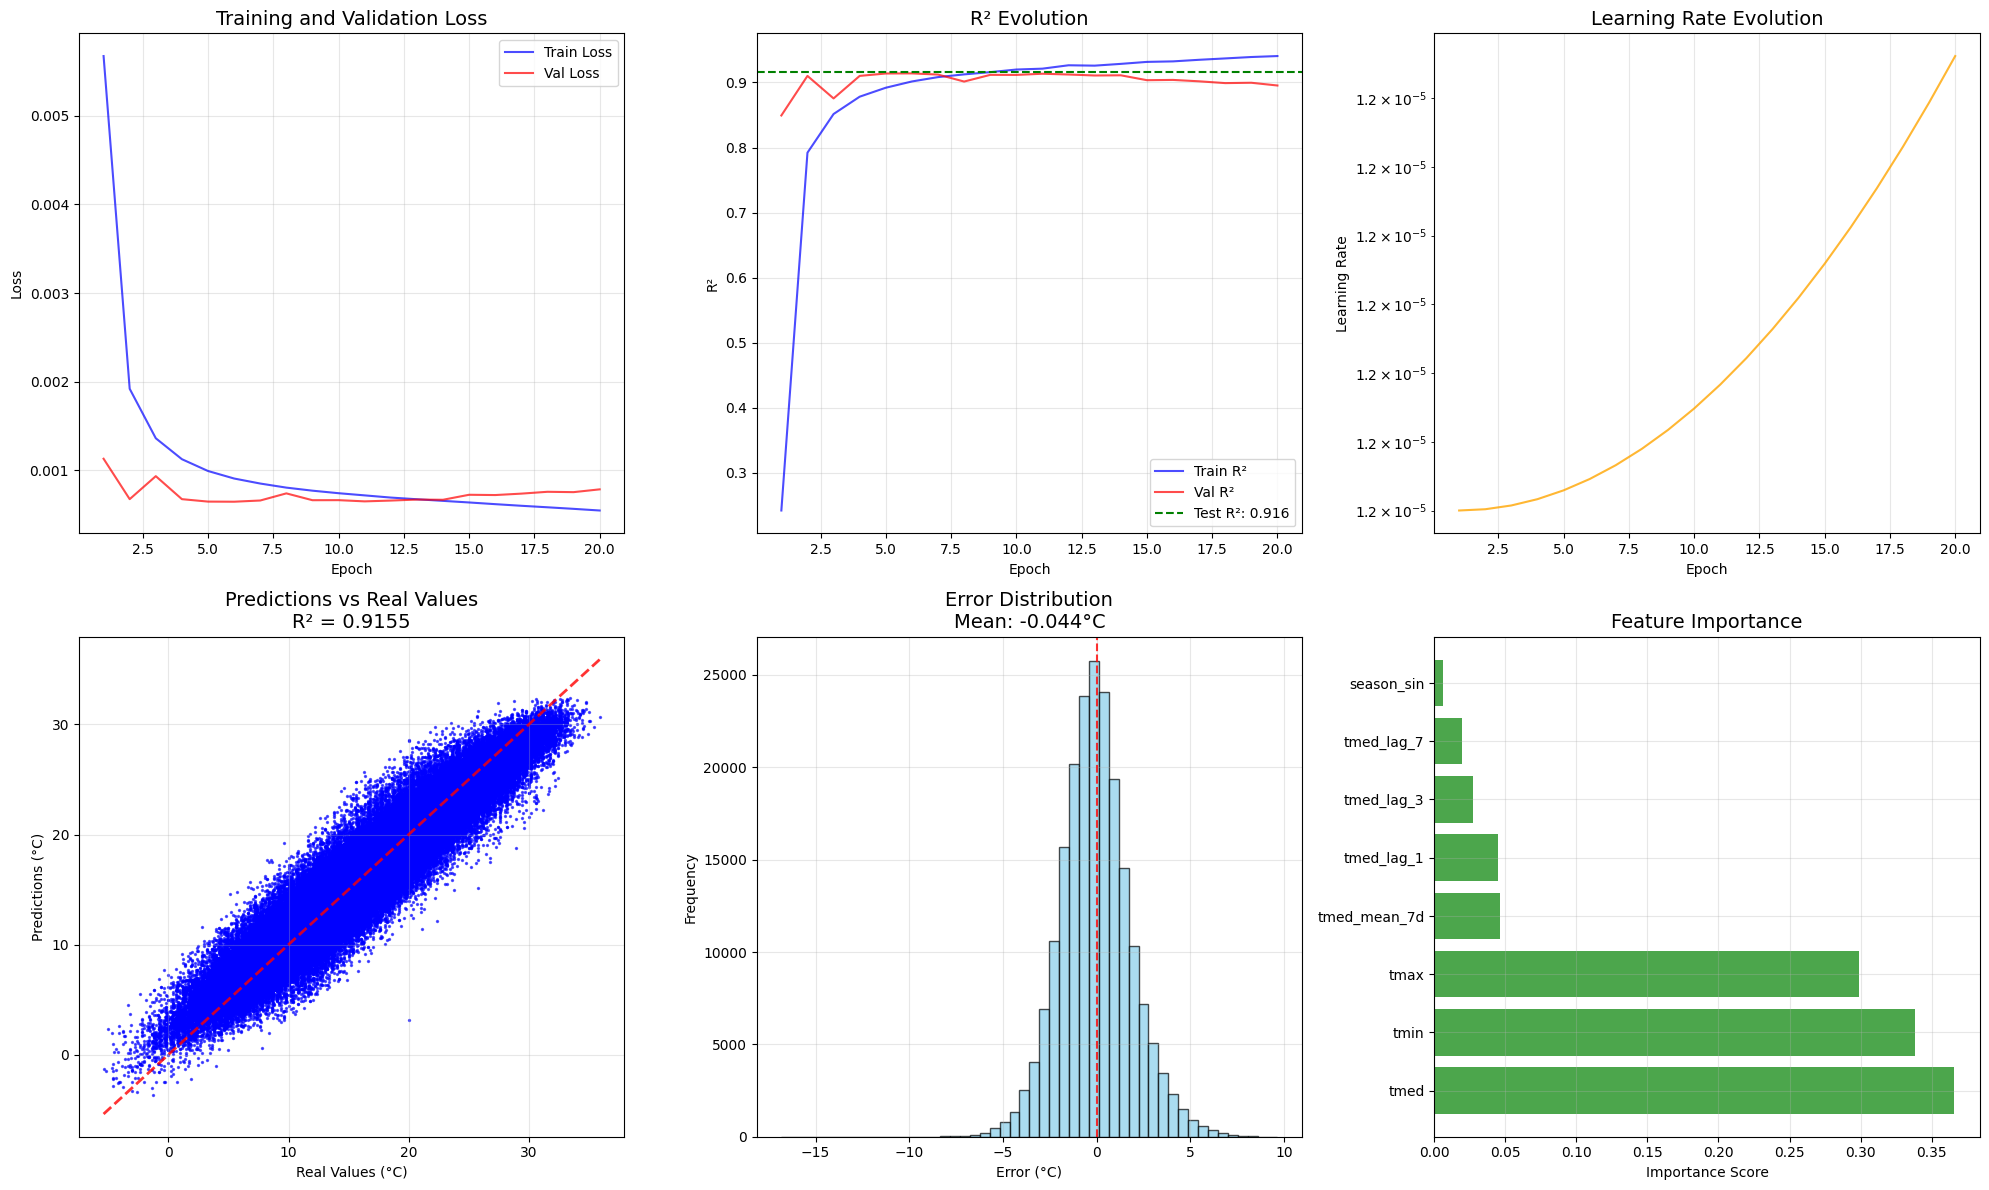


RESIDUAL ANALYSIS:
  Mean error: -0.044°C
  Error std: 1.893°C
  Median error: -0.109°C
  Predictions within ±1°C: 44.2%
  Predictions within ±2°C: 73.8%

Production model saved as 'production_weather_model.pth'

EVALUATION COMPLETED
EXCELLENT: R² > 0.85 - High quality model ready for production

Generated files:
  - best_model_checkpoint.pth (training checkpoint)
  - production_weather_model.pth (production model)
  - training_history.json (training history)
  - scaler_X_production.joblib (feature scaler)
  - scaler_y_production.joblib (target scaler)
  - label_encoder_global_all_stations.joblib (station encoder)


In [ ]:
# Evaluación completa


def comprehensive_evaluation(model, test_loader, scaler_y, device):
    """Evaluación completa del modelo"""
    print("Starting comprehensive evaluation...")
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            if targets.dim() == 1:
                targets = targets.unsqueeze(1)
            
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Convertir a arrays
    predictions = np.array(all_predictions).flatten()
    targets = np.array(all_targets).flatten()
    
    # Desnormalizar
    predictions_denorm = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    targets_denorm = scaler_y.inverse_transform(targets.reshape(-1, 1)).flatten()
    
    # Calcular métricas
    metrics = {
        'mae': mean_absolute_error(targets_denorm, predictions_denorm),
        'rmse': np.sqrt(mean_squared_error(targets_denorm, predictions_denorm)),
        'r2': r2_score(targets_denorm, predictions_denorm),
        'mape': np.mean(np.abs((targets_denorm - predictions_denorm) / targets_denorm)) * 100
    }
    
    # Análisis de errores por rangos de temperatura
    temp_ranges = [
        ('Cold', -10, 10),
        ('Moderate', 10, 25),
        ('Warm', 25, 40)
    ]
    
    range_metrics = {}
    for range_name, min_temp, max_temp in temp_ranges:
        mask = (targets_denorm >= min_temp) & (targets_denorm < max_temp)
        if mask.sum() > 0:
            range_predictions = predictions_denorm[mask]
            range_targets = targets_denorm[mask]
            range_metrics[range_name] = {
                'count': mask.sum(),
                'mae': mean_absolute_error(range_targets, range_predictions),
                'r2': r2_score(range_targets, range_predictions)
            }
    
    return metrics, range_metrics, predictions_denorm, targets_denorm

def analyze_feature_importance(model, test_loader, scaler_y, device, feature_names, n_samples=500):
    """Análisis de importancia de features usando perturbación"""
    print("Analyzing feature importance...")
    
    model.eval()
    
    # Tomar muestra aleatoria
    sample_data = []
    sample_targets = []
    count = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            if count >= n_samples:
                break
            
            batch_size = min(inputs.shape[0], n_samples - count)
            sample_data.append(inputs[:batch_size])
            sample_targets.append(targets[:batch_size])
            count += batch_size
    
    sample_inputs = torch.cat(sample_data, dim=0).to(device)
    sample_targets = torch.cat(sample_targets, dim=0).to(device)
    
    # Baseline predictions
    baseline_pred = model(sample_inputs)
    baseline_mae = F.l1_loss(baseline_pred, sample_targets.unsqueeze(1) if sample_targets.dim() == 1 else sample_targets)
    
    feature_importance = {}
    
    for i, feature_name in enumerate(feature_names):
        # Perturbar feature
        perturbed_inputs = sample_inputs.clone()
        perturbed_inputs[:, :, i] = torch.randn_like(perturbed_inputs[:, :, i]) * 0.1
        
        # Predicción con feature perturbada
        perturbed_pred = model(perturbed_inputs)
        perturbed_mae = F.l1_loss(perturbed_pred, sample_targets.unsqueeze(1) if sample_targets.dim() == 1 else sample_targets)
        
        # Importancia = aumento en error
        importance = (perturbed_mae - baseline_mae).item()
        feature_importance[feature_name] = importance
    
    return feature_importance

# Cargar mejor modelo
checkpoint = torch.load('best_model_checkpoint.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluación completa
metrics, range_metrics, test_predictions, test_targets = comprehensive_evaluation(
    model, test_loader, scaler_y, DEV
)

# Análisis de importancia
feature_importance = analyze_feature_importance(
    model, test_loader, scaler_y, DEV, available_features, n_samples=500
)

# Mostrar resultados
print(f"\nFINAL MODEL METRICS:")
print(f"  MAE:  {metrics['mae']:.2f}°C")
print(f"  RMSE: {metrics['rmse']:.2f}°C")
print(f"  R²:   {metrics['r2']:.4f}")
print(f"  MAPE: {metrics['mape']:.2f}%")

print(f"\nTEMPERATURE RANGE ANALYSIS:")
for range_name, range_data in range_metrics.items():
    print(f"  {range_name}: {range_data['count']} samples | "
          f"MAE: {range_data['mae']:.2f}°C | R²: {range_data['r2']:.3f}")

print(f"\nFEATURE IMPORTANCE:")
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features[:5]:
    print(f"  {feature:15s}: {importance:+.4f}")

# Gráficos de evaluación
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Training history
axes[0, 0].plot(history["epochs"], history["train_loss"], label="Train Loss", color='blue', alpha=0.7)
axes[0, 0].plot(history["epochs"], history["val_loss"], label="Val Loss", color='red', alpha=0.7)
axes[0, 0].set_title("Training and Validation Loss", fontsize=14)
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. R² evolution
axes[0, 1].plot(history["epochs"], history["train_r2"], label="Train R²", color='blue', alpha=0.7)
axes[0, 1].plot(history["epochs"], history["val_r2"], label="Val R²", color='red', alpha=0.7)
axes[0, 1].axhline(y=metrics['r2'], color='green', linestyle='--', label=f'Test R²: {metrics["r2"]:.3f}')
axes[0, 1].set_title("R² Evolution", fontsize=14)
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("R²")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Learning rate
axes[0, 2].plot(history["epochs"], history["lr"], color='orange', alpha=0.8)
axes[0, 2].set_title("Learning Rate Evolution", fontsize=14)
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Learning Rate")
axes[0, 2].set_yscale('log')
axes[0, 2].grid(True, alpha=0.3)

# 4. Scatter plot predicciones vs reales
axes[1, 0].scatter(test_targets, test_predictions, alpha=0.6, s=2, color='blue')
axes[1, 0].plot([test_targets.min(), test_targets.max()], 
               [test_targets.min(), test_targets.max()], 'r--', lw=2, alpha=0.8)
axes[1, 0].set_xlabel("Real Values (°C)")
axes[1, 0].set_ylabel("Predictions (°C)")
axes[1, 0].set_title(f"Predictions vs Real Values\nR² = {metrics['r2']:.4f}", fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# 5. Distribución de errores
errors = test_predictions - test_targets
axes[1, 1].hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel("Error (°C)")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title(f"Error Distribution\nMean: {errors.mean():.3f}°C", fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

# 6. Feature importance
features, importances = zip(*sorted_features[:8])
axes[1, 2].barh(range(len(features)), importances, alpha=0.7, color='green')
axes[1, 2].set_yticks(range(len(features)))
axes[1, 2].set_yticklabels(features)
axes[1, 2].set_xlabel('Importance Score')
axes[1, 2].set_title('Feature Importance', fontsize=14)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de residuos
print(f"\nRESIDUAL ANALYSIS:")
residuals = test_predictions - test_targets

print(f"  Mean error: {residuals.mean():.3f}°C")
print(f"  Error std: {residuals.std():.3f}°C")
print(f"  Median error: {np.median(residuals):.3f}°C")
print(f"  Predictions within ±1°C: {(np.abs(residuals) <= 1).mean()*100:.1f}%")
print(f"  Predictions within ±2°C: {(np.abs(residuals) <= 2).mean()*100:.1f}%")

# Guardar modelo final en formato de producción
final_model_info = {
    'model_state_dict': model.state_dict(),
    'config': checkpoint['config'],
    'features': available_features,
    'metrics': metrics,
    'training_history': history,
    'feature_importance': feature_importance
}

torch.save(final_model_info, 'production_weather_model.pth')
print(f"\nProduction model saved as 'production_weather_model.pth'")

print(f"\nEVALUATION COMPLETED")
if metrics['r2'] > 0.85:
    print(f"EXCELLENT: R² > 0.85 - High quality model ready for production")
elif metrics['r2'] > 0.75:
    print(f"GOOD: R² > 0.75 - Acceptable model for production")
else:
    print(f"NEEDS IMPROVEMENT: R² < 0.75 - Consider more data or model adjustments")

print(f"\nGenerated files:")
print(f"  - best_model_checkpoint.pth (training checkpoint)")
print(f"  - production_weather_model.pth (production model)")
print(f"  - training_history.json (training history)")
print(f"  - scaler_X_production.joblib (feature scaler)")
print(f"  - scaler_y_production.joblib (target scaler)")
print(f"  - label_encoder_global_all_stations.joblib (station encoder)")
